# Notebook with VAE model and no conditionning

## Loading Libraries 

In [58]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images

In [59]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/CVAE/marota_cvae'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [83]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import NEpochLogger,callbackWeightLoss
#from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE, CVAE_emb, CAE
from conso.load_shape_data import *  

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

In [61]:
#directories to store trained model and the related projector

log_dir_projector=path_main_folder+"/notebooks/logs/Expe-bike/VAE/projector"
log_dir_model=path_main_folder+"/notebooks/logs/Expe-bike/VAE/model"
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)

# Table of contents:
- Load Data
- Make Training Set
- Define and Train Model
- Build Projector
- Compute Feature Scores in latent space
- Study reconstruction Error
- Study Holidays prediction
- Detect atypical events
- Conclusion

# Load dataset 

In [62]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data/bike-sharing')
dataset_train= os.path.join(path_data, "train.csv")
dataset_test= os.path.join(path_data, "test.csv")

train = pd.read_csv(dataset_train)
test = pd.read_csv(dataset_test)
train.head()
train.datetime = pd.to_datetime(train.datetime)

In [63]:
dates, freq = np.unique(train.datetime.dt.date, return_counts=True)
stats.describe(freq)

DescribeResult(nobs=456, minmax=(12, 24), mean=23.87280701754386, variance=0.4233468286099864, skewness=-13.815185164323347, kurtosis=242.2238235069406)

In [64]:
target = dates[np.argmin(freq)]
ind = np.where(train.datetime.dt.date==target)[0]
train = train.drop(index=ind)

In [65]:
#Visualize data frame head
x_conso = train[['datetime', 'count', 'temp', 'humidity', 'windspeed', 'holiday']].copy()
x_conso[['count', 'temp', 'humidity', 'windspeed', 'holiday']] = x_conso[['count', 'temp', 'humidity', 'windspeed', 'holiday']].astype('float64').values
x_conso = x_conso.rename(columns={'datetime':'ds', 'count':'consumption', 'temp':'temperature', 'holiday':'is_holiday_day'})
x_conso.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10874 entries, 0 to 10885
Data columns (total 6 columns):
ds                10874 non-null datetime64[ns]
consumption       10874 non-null float64
temperature       10874 non-null float64
humidity          10874 non-null float64
windspeed         10874 non-null float64
is_holiday_day    10874 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 594.7 KB


# Make training set of daily electrical consumption profiles and conditions 
In this experiment there is no condition to pass. This is not something we can do with a PCA anyway

In [66]:
dict_xconso = {'train': x_conso}
name_set_plot = 'train'
version = '-v1'
# Normalize input variables
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard', meteo_elements=['temperature', 'humidity', 'windspeed'])
dict_xconso['train'].describe()

['consumption']


,consumption,temperature,humidity,windspeed,is_holiday_day
count,1.087400e+04,1.087400e+04,1.087400e+04,1.087400e+04,10874.000000
mean,-4.181969e-17,-1.150042e-16,-8.886685e-17,9.409431e-17,0.028600
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,0.166688
min,-1.052696e+00,-2.494529e+00,-3.215629e+00,-1.567853e+00,0.000000
25%,-8.208763e-01,-8.095381e-01,-7.724447e-01,-7.104285e-01,0.000000
50%,-2.578865e-01,3.295719e-02,7.294971e-03,2.392095e-02,0.000000
75%,5.093251e-01,7.701406e-01,7.870346e-01,5.137608e-01,0.000000
max,4.334344e+00,2.665755e+00,1.982635e+00,5.412159e+00,1.000000


In [67]:
timeserie = train.datetime.dt
nPoints = len(np.unique(timeserie.date))
nPoints

455

In [68]:
# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption']


In [69]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)

month (455, 12)
weekday (455, 1)
(455, 13)


In [70]:
#A VAE is a CVAE with a null feature as a condition  

#Pass a constant vector for conditions
nPoints=dataset['train']['x'][1].shape[0]
x = dataset['train']['x'][0]
cond_pre =np.zeros((nPoints,), dtype=int)#

dataset['train']['x'] = [x,cond_pre]
dataset['train']['y1'] = dataset['train']['y'] #the CVAE model has two outputs which are identifcal to compute the two losses

In [71]:
sum(np.isnan(dataset['train']['x'][0]))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [72]:
sum(np.isnan(dataset['train']['y']))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [73]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0

In [74]:
dates = calendar_info['ds'].dt.date
weather = [train.weather.iloc[np.where(train['datetime'].dt.date==date)[0]].max() for date in dates]
calendar_info=calendar_info.join(pd.get_dummies(weather).rename(columns={1:'clear', 2:'mist', 3:'significant', 4:'extreme'}))
calendar_info.head()

,ds,month,weekday,is_weekday,is_holiday_day,clear,mist,significant,extreme
0,2011-01-01,1,5,0,0.0,0,0,1,0
1,2011-01-02,1,6,0,0.0,0,0,1,0
2,2011-01-03,1,0,1,0.0,1,0,0,0
3,2011-01-04,1,1,1,0.0,0,1,0,0
4,2011-01-05,1,2,1,0.0,1,0,0,0


# Build and train model VAE

In [75]:
#on sauvegarde le dataset
path_out = log_dir_model

In [77]:
# Parameters for autoencoder
e_dims=[24,18,12,6]#encoder dim
d_dims=[24,18,12,6]#decoder dim. Dense Blocks in skip connections can make the dimensions bigger when layers are concatenated with the previous one
to_emb_dim=[]
cond_pre_dim = 0#dataset['train']['x'][1].shape[1]
input_dim = dataset['train']['x'][0].shape[1]
z_dim= 4
lambda_val = 0.4

In [78]:
name_model = 'vae_conso-1h-journalier-nocond'
#name_model = 'cvae_classification'

In [85]:
#if needs to relaod model classes after modification wothout restarting the kernel

import CVAE.cvae_model
import CVAE.callbacks
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.callbacks)

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
Lambda = K.variable(lambda_val, dtype='float32')
model = CVAE.cvae_model.CVAE(input_dim=input_dim,
             cond_dim=1, 
             e_dims=e_dims, 
             d_dims=d_dims, 
             z_dim=z_dim, 
             beta=Lambda,
             name=name_model, 
             output=path_out,is_L2_Loss=False,lr=3e-4)

L1 loss
False
L1 loss
False
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 24)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 1472        x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)         

### Trainning model 

In [87]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=False,histogram_freq=50,write_grads=True,write_images=True)#,,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)



--- START TRAINING ---

[ 73.93711 349.4256  261.62344 255.7723 ]
14.822064492753618
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.896038  0.317271  0.153915        0.123077    -5.260497
random model    0.466407  0.137887  0.065411        0.046154    -5.907602
0 Epochs ...  - loss: 19.6761 - decoder_loss: 19.2451 - decoder_for_kl_loss: 1.0775 - decoder_kl_loss: 1.0775 - decoder_recon_loss: 19.2451 - decoder_for_kl_kl_loss: 1.0775 - decoder_for_kl_recon_loss: 19.2451 - val_loss: 21.1359 - val_decoder_loss: 20.6378 - val_decoder_for_kl_loss: 1.2454 - val_decoder_kl_loss: 1.2454 - val_decoder_recon_loss: 20.6378 - val_decoder_for_kl_kl_loss: 1.2454 - val_decoder_for_kl_recon_loss: 20.6378 val_loss 21.13593449799911 ... lambda Loss 0.4000000059604645
[380.1123  376.58618 394.37894 207.30388]
12.146131159420285
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.951221  0.409705  0.215721        0.123077

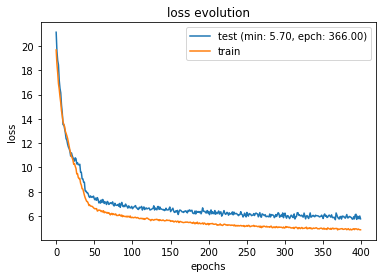

In [88]:
import warnings
warnings.filterwarnings('ignore')

lambda_decreaseRate=0.0
lambda_min=0.01 #p

#Turn it to True to train the model. Otherwise you can directly load on already trained model below
runTraining=True
runBatchCallback=True #In this callback we compute feature scores which is a bit long

if runTraining:#Training a neural network requires some computing power and the CPUs in MyBinder environment can be a bit slow. If you don't use callbacks it can be faster also 
    
    if runBatchCallback:
        out_batch = NEpochLogger(x_train_data=dataset['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
        model.main_train(dataset, training_epochs=400, batch_size=32, verbose=0,callbacks=[tensorboard,out_batch],validation_split=0.1)
    else:
        #use verbose=1 to see logs of training at every epoch
        model.main_train(dataset, training_epochs=400, batch_size=32, verbose=0,callbacks=[tensorboard],validation_split=0.1)




--- START TRAINING ---

[398.98703  363.2824   217.58594   34.782455]
11.52988333333332
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.958625  0.410428  0.180038        0.169231    -2.527644
random model    0.464648  0.156928  0.064628        0.015385    -6.079236
0 Epochs ...  - loss: 4.9149 - decoder_loss: 3.5377 - decoder_for_kl_loss: 3.4430 - decoder_kl_loss: 3.4430 - decoder_recon_loss: 3.5377 - decoder_for_kl_kl_loss: 3.4430 - decoder_for_kl_recon_loss: 3.5377 - val_loss: 5.7936 - val_decoder_loss: 4.3664 - val_decoder_for_kl_loss: 3.5680 - val_decoder_kl_loss: 3.5680 - val_decoder_recon_loss: 4.3664 - val_decoder_for_kl_kl_loss: 3.5680 - val_decoder_for_kl_recon_loss: 4.3664 val_loss 5.79356919164243 ... lambda Loss 0.4000000059604645
[402.33594 362.54727 132.57204  30.24712]
11.267483333333331
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.961246  0.406845  0.203088        0.169231    -2

[386.14273  376.83145   13.743119  20.957647]
12.011960144927537
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.967859  0.396655  0.246882        0.138462    -2.490550
random model    0.484777  0.142323  0.114111        0.030769    -5.700037
1100 Epochs ...  - loss: 3.4676 - decoder_loss: 2.8231 - decoder_for_kl_loss: 4.8432 - decoder_kl_loss: 4.8432 - decoder_recon_loss: 2.8231 - decoder_for_kl_kl_loss: 4.8432 - decoder_for_kl_recon_loss: 2.8231 - val_loss: 4.4455 - val_decoder_loss: 3.7925 - val_decoder_for_kl_loss: 4.9071 - val_decoder_kl_loss: 4.9071 - val_decoder_recon_loss: 3.7925 - val_decoder_for_kl_kl_loss: 4.9071 - val_decoder_for_kl_recon_loss: 3.7925 val_loss 4.445501534835152 ... lambda Loss 0.13307516276836395
[379.34415  384.96484   12.571158  19.29156 ]
11.641266666666663
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.958799  0.397385  0.253132        0.138462    -2.439116
random m

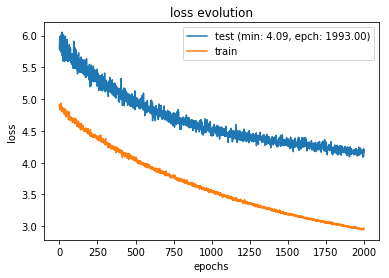

In [89]:
lambda_decreaseRate=0.001 #parameter by default

if runTraining:
    weightLoss=callbackWeightLoss(lambda_val,lambda_decreaseRate,lambda_min)
    if runBatchCallback:
        model.main_train(dataset, training_epochs=2000, batch_size=32, verbose=0,callbacks=[tensorboard,out_batch,weightLoss],validation_split=0.1)
    else:
        model.main_train(dataset, training_epochs=2000, batch_size=32, verbose=0,callbacks=[tensorboard,weightLoss],validation_split=0.1)


DimsImportance=[1616  1403    21 1375 ] Only 3 dimensions are significant here (each term is the sum of absolute values in each direction for the all the datapoints.
There is no significant overfitting when comparing training error to validation error. This will be confimed later on specific examples.

In [90]:
with open(os.path.join(path_out,name_model,"config.txt"),'w') as file: 
    file.write(str(cond_pre_dim) + '\n')
    #file.write(str(emb_dims) + '\n')
    file.write(str(e_dims) + '\n') 
    file.write(str(d_dims) + '\n') 
    file.write(str(z_dim) + '\n')
    file.write(str(Lambda) + '\n')

In [91]:
#sauvegarde du dataset associé
name_dataset = 'dataset.pickle'

with open( os.path.join(path_out,name_model, name_dataset), "wb" ) as file:
    pickle.dump( dataset, file )

## Loading model 

In [92]:
model.load_model(os.path.join(path_out, name_model, 'models'))

In [93]:


#cond  = dataset['train']['x'][1]
x_input = dataset['train']['x'][0]

input_encoder = [x_input, cond_pre]

In [94]:
x_encoded = model.encoder.predict(input_encoder)[0]
x_hat = model.cvae.predict(x=dataset['train']['x'])[0]

# Analysis of the latent space with the construction of a tensorboard projector

In [95]:
includeConsumptionProfileImages=True #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
if includeConsumptionProfileImages:
    nPoints=min(1500,nPoints) #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
    x_encoded_reduced=x_encoded[0:nPoints,]
    images=createLoadProfileImages(x,x_hat,nPoints)
else:
    nPoints=nPoints

<Figure size 432x288 with 0 Axes>

In [96]:
if includeConsumptionProfileImages:
    sprites=images_to_sprite(images)
    cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)

In [97]:

writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
if includeConsumptionProfileImages:
    buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
else:
    buildProjector(x_encoded,images=None, log_dir=log_dir_projector)

In [98]:
log_dir_projector

'/home/goubetcle/Documents/CVAE/marota_cvae/notebooks/logs/Expe-bike/VAE/projector'

# Predict Features in latent space

In [99]:
df_noCond_VAE=predictFeaturesInLatentSPace(x_conso,calendar_info,x_encoded)

11.87633333333332
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.958500  0.415811  0.245405        0.169231    -2.486928
random model    0.478621  0.175324  0.060550        0.030769    -5.657099


# reconstruction error analysis

In [100]:
error=np.sum(np.abs((x - x_hat)),axis=1)/24

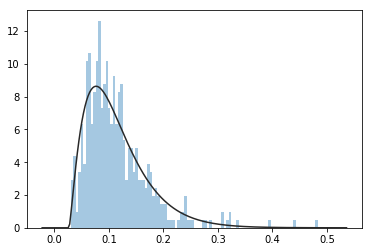

In [101]:
#make a histogram over residuals
import seaborn as sn
sn.distplot(error, kde=False, fit=stats.beta, bins=100)

Check the day with errors above a threshold

In [47]:
ErrorThreshold=0.25
idxMaxError=[i for i in range(0,nPoints) if error[i]>=ErrorThreshold]
calender_error=calendar_info.loc[idxMaxError]
calender_error['error']=error[idxMaxError]

calender_error

,ds,month,weekday,is_weekday,is_holiday_day,clear,mist,significant,extreme,error
243,2012-01-17,1,1,1,0.0,0,0,1,0,0.257170
311,2012-05-09,5,2,1,0.0,0,0,1,0,0.336503
322,2012-06-01,6,4,1,0.0,0,0,1,0,0.402304
344,2012-07-04,7,2,1,1.0,0,1,0,0,0.374608
369,2012-08-10,8,4,1,0.0,0,0,1,0,0.266133
378,2012-08-19,8,6,0,0.0,0,0,1,0,0.284062
399,2012-10-02,10,1,1,0.0,0,0,1,0,0.296377
412,2012-10-15,10,0,1,0.0,0,0,1,0,0.285492
416,2012-10-19,10,4,1,0.0,0,0,1,0,0.269747
423,2012-11-07,11,2,1,0.0,0,0,1,0,0.287136


Check the first n days with highest errors 

In [48]:
nDays=30

decreasingOrderIdx=np.argsort(-error)
calendar_Error_Highest=calendar_info.loc[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest['error']=error[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest

,ds,month,weekday,is_weekday,is_holiday_day,clear,mist,significant,extreme,error
322,2012-06-01,6,4,1,0.0,0,0,1,0,0.402304
344,2012-07-04,7,2,1,1.0,0,1,0,0,0.374608
311,2012-05-09,5,2,1,0.0,0,0,1,0,0.336503
399,2012-10-02,10,1,1,0.0,0,0,1,0,0.296377
423,2012-11-07,11,2,1,0.0,0,0,1,0,0.287136
412,2012-10-15,10,0,1,0.0,0,0,1,0,0.285492
378,2012-08-19,8,6,0,0.0,0,0,1,0,0.284062
416,2012-10-19,10,4,1,0.0,0,0,1,0,0.269747
369,2012-08-10,8,4,1,0.0,0,0,1,0,0.266133
243,2012-01-17,1,1,1,0.0,0,0,1,0,0.257170


Visualize the reconstruction error over a specific day

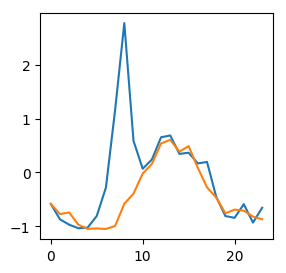

In [49]:
indice=322 #1185 is the changing hour day end of march
fig = plt.figure(dpi=100,figsize=(3,3))
#set(gca,'Color','k')
plt.plot(x[indice,:])
plt.plot(x_hat[indice,:])

Visualize the reconstruction error over the days with highest error

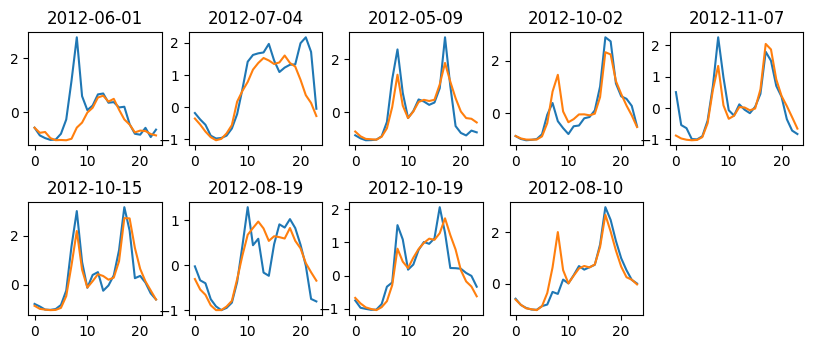

In [50]:
nPlots=10#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,2*nRows))
for i in range(1, nPlots):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=decreasingOrderIdx[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_Error_Highest.ds.dt.date.iloc[i-1])

2013-03-31 is the day with a missing hour because of changing day time and the consumption value is set to 0. It is hence normal that it is not well predicted and a good indicator that the model does not tend to overfit.

# Study of holiday predictions

In [51]:
#preparation des features d'interet
yHd=calendar_info['is_holiday_day'].astype(int)
indicesHd=np.array([i for i in range(0, nPoints) if yHd[i] == 1])
yHd_only=yHd[yHd==1]
x_encoded_Hd=x_encoded[indicesHd,]

In [52]:
results_hd=scoreKnnResults(x_encoded,yHd,type='classifier',k=5,cv=10)

## holidays well predicted

In [53]:
results_hd_only=[results_hd['predP'][i] for i in indicesHd ]
indices_Hd_predict=[i for i in indicesHd if  results_hd['predP'][i]>=0.5]
indices_Hd_not_predicted=[i for i in indicesHd if  results_hd['predP'][i]<0.5]
calendar_info.loc[indices_Hd_predict]

,ds,month,weekday,is_weekday,is_holiday_day,clear,mist,significant,extreme
344,2012-07-04,7,2,1,1.0,0,1,0,0
405,2012-10-08,10,0,1,1.0,0,0,1,0


In [54]:
yWeekday=calendar_info['is_weekday']
results_wk=scoreKnnResults(x_encoded,yWeekday,type='classifier',k=10,cv=10)

In [56]:
weekdays_predicted_as_weekend=[i for i in range(0,nPoints) if  results_wk['predP'][i]<=0.5 and yWeekday[i]==1]
calendar_info.loc[weekdays_predicted_as_weekend]

,ds,month,weekday,is_weekday,is_holiday_day,clear,mist,significant,extreme
16,2011-01-17,1,0,1,1.0,0,0,1,0
116,2011-07-04,7,0,1,1.0,0,1,0,0
155,2011-09-05,9,0,1,1.0,0,0,1,0
158,2011-09-08,9,3,1,0.0,0,0,1,0
179,2011-10-10,10,0,1,1.0,0,1,0,0
228,2012-01-02,1,0,1,1.0,0,1,0,0
242,2012-01-16,1,0,1,1.0,0,0,1,0
322,2012-06-01,6,4,1,0.0,0,0,1,0
381,2012-09-03,9,0,1,1.0,0,1,0,0


In [57]:
len(weekdays_predicted_as_weekend)

9

We find out that holidays actually look alike weekends even if they are happening during weekdays. Days with significant bad weather are predicted the same way for bike sharing.

# Holidays & nearest neighbors

<function matplotlib.pyplot.show(*args, **kw)>

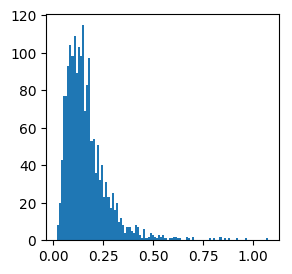

In [104]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(10)
neigh.fit(x_encoded)

[distance_knn,kneighbors]=neigh.kneighbors(x_encoded, 2, return_distance=True)
nearest=distance_knn[:,1]
fig = plt.figure(dpi=100,figsize=(3,3))
plt.hist(nearest,bins=100)
plt.show

In [105]:
from scipy import stats

stats.describe(nearest)

DescribeResult(nobs=1830, minmax=(0.016541171424242395, 1.074540498547887), mean=0.16673077278509163, variance=0.012510367346743085, skewness=2.5012268081450864, kurtosis=10.545053959091563)

<function matplotlib.pyplot.show(*args, **kw)>

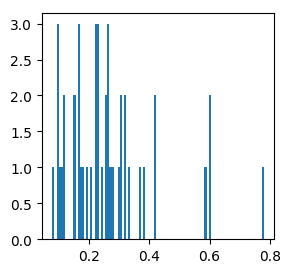

In [106]:
fig = plt.figure(dpi=100,figsize=(3,3))
plt.hist(nearest[indicesHd],bins=100)
plt.show

In [107]:
stats.describe(nearest[indicesHd])

DescribeResult(nobs=45, minmax=(0.07724092920572362, 0.7800549293110298), mean=0.2631268081068916, variance=0.022468491085609967, skewness=1.4799056215452613, kurtosis=2.342934273043145)

In [108]:
nearestThreshold=0.7
calendar_info.loc[np.where(nearest>=nearestThreshold)]

,ds,month,weekday,is_weekday,is_holiday_day
21,2013-01-18,1,4,1,0.0
361,2013-12-24,12,1,1,0.0
703,2014-12-01,12,0,1,0.0
719,2014-12-17,12,2,1,0.0
730,2014-12-28,12,6,0,0.0
1092,2015-12-25,12,4,1,1.0
1120,2016-01-22,1,4,1,0.0
1466,2017-01-02,1,0,1,0.0
1491,2017-01-27,1,4,1,0.0
1583,2017-04-29,4,5,0,0.0


2013-01-18  and 2017-01-27 were big snowy events in France and first of january are alwaus atypical days. All of those events happened durng winter, when the electrical consumption is most sensitive to temperature.

In [110]:
indicesNear=[i for i in range(0,len(nearest)) if nearest[i]>=nearestThreshold]
nearest[np.where(nearest>=nearestThreshold)]

array([0.95991154, 0.80261123, 1.0745405 , 0.85577207, 0.91793625,
       0.78005493, 0.84032683, 0.70019336, 0.84032683, 0.87500159])

<bound method Figure.show of <Figure size 1000x600 with 10 Axes>>

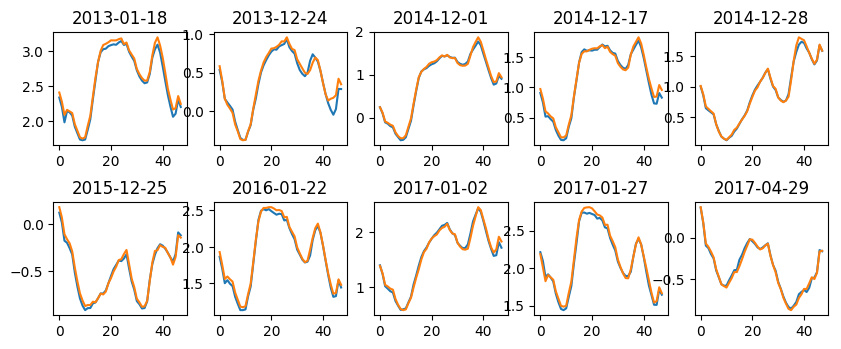

In [111]:
nPlots=len(indicesNear)#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,2*nRows))
for i in range(1, nPlots+1):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=indicesNear[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_info.ds.dt.date.iloc[indice])
fig.show

# Conclusions
- 3 dimensions covers most of the information for the variety of daily load curves 
- We recovered with this simple linear model the two main features that caracterizes electrical consumption: weekday and temperature
- Holidays are not yet well predicted and represented, although we know they are an important atypical factor.
- We however detect that holidays all look alike weekend days
- We discover some first interpretable events.
- Results are quite similar than with the PCA model. They are some differences in the events first detected. The projection in the latent space is also more gaussian, which ease the interactive navigation in it, compared to the PCA projection.

